# Hourly prediction
- goal is the most accurate prediction of net load

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from tbats import TBATS
from green_city.utils import metrics_dict, datetime2index, index2datetime

plt.rcParams['figure.figsize'] = [25, 8]

In [2]:
## MLFLOW ##
import mlflow
from green_city.mlflow_config import get_mlflow_config

flow_conf = get_mlflow_config()
tracking_uri = flow_conf["TRACKING_URI"]
mlflow.set_tracking_uri(flow_conf["TRACKING_URI"])
mlflow.set_experiment(flow_conf["EXPERIMENT_NAME"]);

In [3]:
## DB CONNECTION ##
from sqlalchemy import create_engine
from decouple import Config, RepositoryEnv

config = Config(RepositoryEnv("../.db_credentials"))

db_connection_credentials = {
    "database": config('POSTGRES_DB'),
    "user": config('POSTGRES_USER'),
    "password": config('POSTGRES_PASSWORD'),
    "host": config('POSTGRES_HOST'),
    "port": config('POSTGRES_PORT'),
}
DB_STRING = "postgresql://{user}:{password}@{host}:{port}/{database}".format(**db_connection_credentials)
db = create_engine(DB_STRING)

In [4]:
#document wide parameters that don't change in experiments
#for logging to mlflow server
global_params = {
    "feature": "net_load_kWh",
    "building_nr": 5,
    "resolution": "H",
    "pred_steps": 24,
}

In [5]:
assert global_params["resolution"] == "H"

# Load the dataset
def get_df(building_nr, feature):
    df = (
    pd.read_csv(f"../data/preprocessed/Building_{building_nr}.csv")
        .astype({'datetime': 'datetime64'})
        [[feature, "datetime"]]
        .rename(columns={feature: "actual"})
    )
    df.index.name = "id"
    return df

df = get_df(global_params["building_nr"], global_params["feature"])
df

,actual,datetime
id,,
0,16.31,2008-01-02 00:00:00
1,11.03,2008-01-02 01:00:00
2,9.04,2008-01-02 02:00:00
3,13.71,2008-01-02 03:00:00
4,9.19,2008-01-02 04:00:00
...,...,...
35035,12.28,2011-12-31 19:00:00
35036,15.18,2011-12-31 20:00:00
35037,14.49,2011-12-31 21:00:00


In [6]:
plotting = False
if plotting:
    #Plotting the data to get a bit of an overview
    fig, (ax1, ax2) = plt.subplots(2, 1)
    df.actual.plot(ax=ax1, xlabel="");
    #ax1.set_xlabel("")
    plot_acf(df.actual, lags=370, ax=ax2);
    plt.subplots_adjust(hspace=0.2)

In [7]:
# prediction function
def predict_next_hours(index=None,
                       time=None,
                       data=None,
                       pred_steps=24,
                       train_steps=None,
                       model='TBATS',
                       seasonalities=None,
                       **_):
    df = data
    if index is None:
        index = df.loc[df.datetime == time].index[0]
    if seasonalities is None:
        seasonalities = [24]
        if train_steps > 7*24:
            seasonalities.append(7*24)
        if train_steps > 365*24:
            seasonalities.append(365*24)

    print(f"[Predicting the next {pred_steps}h after {df.loc[index, 'datetime']} (row {index})]")

    if train_steps is not None:
        df_train = df.loc[index-train_steps+1:index]
    else:
        df_train = df.loc[:index]

    if model == 'TBATS':
        #estimator = TBATS(seasonal_periods=[24, 7*24, 365*24])
        estimator = TBATS(seasonal_periods=[24])
        fitted_model = estimator.fit(df_train.actual)
        forecast = fitted_model.forecast(steps=pred_steps)

    return pd.DataFrame({"forecast": forecast}, index=range(index+1, index+pred_steps+1))

In [8]:
pred_indices = [32135, 33311, 26478, 33357, 30387, 30794, 31800, 28783]
#pred_times = [str(index2datetime(v)) for v in pred_indices]

for index in pred_indices:
    for train_steps in [100, 200, 400 ,1000]:
        params = global_params.copy()
        params.update({
            #"index": datetime2index(pd.Timestamp(timestr)),
            #"datetime": pd.Timestamp(timestr),
            "index": index,
            "datetime": index2datetime(index),
            "pred_steps": 24,
            "train_steps": train_steps,
            "model": "TBATS",
            "seasonalities": [24],
        })

        with mlflow.start_run(run_name=f"TBATS_{train_steps}") as r:

            ## predict ##
            predictions = predict_next_hours(**params, data=df)
            df_forecast = pd.concat([df, predictions], axis=1)
            df_forecast.index.name = df.index.name
            df_forecast["error"] = df_forecast.actual - df_forecast.forecast

            ## evaluate ##
            pred_lims = (params["index"]+1, params["index"]+params["pred_steps"])
            df_predrange = df_forecast.loc[pred_lims[0]:pred_lims[1]]

            metrics = metrics_dict(df_predrange.actual, df_predrange.forecast, ["mae", "mse", "r2_score"])
            print("mae: {mae}, mse: {mse}, r2: {r2_score}".format(**metrics))
            mlflow.log_metrics(metrics)

            ## logging ##
            mlflow.log_params(params)
            
            ## save result to database ##
            #needs to be a table with ["id", "prediction", "run_id"] as columns (which can include the index-column)
            forecasts = df_predrange[["forecast"]].assign(run_id = r.info.run_id).rename(columns={"forecast": "prediction"})
            forecasts.to_sql("forecast", con=db, if_exists="append")
            

[Predicting the next 24h after 2011-09-01 23:00:00 (row 32135)]
mae: 5.02208673062236, mse: 41.819045282962215, r2: 0.6854634187056463
[Predicting the next 24h after 2011-09-01 23:00:00 (row 32135)]
mae: 5.109093243821394, mse: 40.68758313517662, r2: 0.693973566018202
[Predicting the next 24h after 2011-09-01 23:00:00 (row 32135)]
mae: 5.228396961973308, mse: 51.29651177979762, r2: 0.6141798709566282
[Predicting the next 24h after 2011-09-01 23:00:00 (row 32135)]
mae: 5.179820802601992, mse: 49.69065239815375, r2: 0.6262581361710546
[Predicting the next 24h after 2011-10-20 23:00:00 (row 33311)]
mae: 7.202839260694982, mse: 78.89333304380357, r2: 0.13184125697381777
[Predicting the next 24h after 2011-10-20 23:00:00 (row 33311)]
mae: 5.223975218092852, mse: 49.28954178887489, r2: 0.4576075697041804
[Predicting the next 24h after 2011-10-20 23:00:00 (row 33311)]
mae: 4.984938291050945, mse: 41.943357919853185, r2: 0.5384465139813612
[Predicting the next 24h after 2011-10-20 23:00:00 (ro

run_id: 2dc2ad2e895f49708cf2cc3fc458930a
[Predicting the next 24h after 2008-01-04 16:00:00 (row 64)]
mae: 3.3243164792191418, mse: 21.63635251804467, r2: 0.30980889631153086


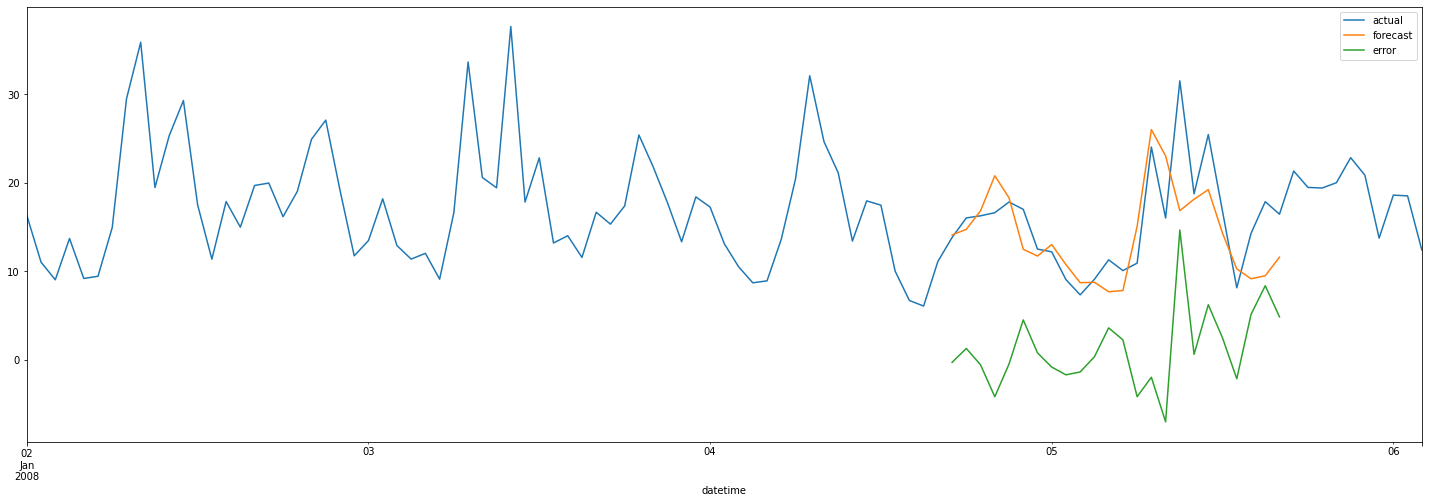

In [9]:
index = 64

params = global_params.copy()
params.update({
    "index": index,
    "datetime": index2datetime(index),
    "pred_steps": 24,
    "train_steps": 200,
    "model": "TBATS",
    "seasonalities": [24],
})

with mlflow.start_run(run_name="TBATS_200_64") as r:
    print(f"run_id: {r.info.run_id}")

    ## predict ##
    predictions = predict_next_hours(**params, data=df)
    df_forecast = pd.concat([df, predictions], axis=1)
    df_forecast.index.name = df.index.name
    df_forecast["error"] = df_forecast.actual - df_forecast.forecast

    ## evaluate ##
    pred_lims = (params["index"]+1, params["index"]+params["pred_steps"])
    df_predrange = df_forecast.loc[pred_lims[0]:pred_lims[1]]

    metrics = metrics_dict(df_predrange.actual, df_predrange.forecast, ["mae", "mse", "r2_score"])
    print("mae: {mae}, mse: {mse}, r2: {r2_score}".format(**metrics))
    mlflow.log_metrics(metrics)

    ## logging ##
    mlflow.log_params(params)

    ## save result to database ##
    #needs to be a table with ["id", "prediction", "run_id"] as columns (which can include the index-column)
    forecasts = df_predrange[["forecast"]].assign(run_id = r.info.run_id).rename(columns={"forecast": "prediction"})
    forecasts.to_sql("forecast", con=db, if_exists="append")
    

df_forecast.loc[:params["index"]+params["pred_steps"]+10].set_index("datetime").plot();

In [10]:
if False:
    start_time = "2009-01-03 22:00"
    
    index_dt = pd.Timestamp.fromisoformat(start_time)
    #second forecast:
    params = global_params.copy()
    params.update({
        "datetime": index_dt,
        "index": datetime2index(index_dt),
        "pred_steps": 24,
        "train_steps": 40,
        "model": "TBATS"
    })
    
    pred_lims = (params["index"]+1, params["index"]+params["pred_steps"])
    train_lims = (params["index"]-params["train_steps"]+1, params["index"])
    
    with mlflow.start_run(run_name="predict_2009") as r:
        forecast_2009 = predict_next_hours(**params, data=df)
        df_w_fc = pd.concat([df, forecast_2009.rename(columns={"forecast": "fc_2009"})], axis=1)
        df_predrange = df_w_fc.loc[pred_lims[0]:pred_lims[1]]
    
        #calculate error
        df_w_fc["error"] = df_w_fc.actual - df_w_fc.fc_2009
    
        metrics = metrics_dict(df_predrange.actual, df_predrange.fc_2009, ["mae", "mse", "r2_score"])
        print("mae: {mae}, mse: {mse}, r2: {r2_score}".format(**metrics))
        mlflow.log_metrics(metrics)
    
        mlflow.log_params(params)
    
    df_w_fc.loc[train_lims[0]:pred_lims[1]+10].set_index('datetime').plot()